# The political and economic consequences of COVID-19

In [83]:
import numpy as np
import pandas as pd
import glob
import config
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sb


## What is happening?

In December, 2019, the first case of the novel coronavirus COVID-19 was discovered in Wuhan, China. The desease seemed to have developed on a wet market in the city of Wuhan and quickly spread across the Province Hubei.

## Data Collection

In [81]:
# load data from https://github.com/CSSEGISandData/COVID-19
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df_death = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')


In [82]:
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,47,48,50,50,50,53,59,70,75,82
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,360,420,461,502,511,581,639,639,701,773
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,117,130,138,150,150,160,178,178,200,212
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,50,83,93,99,117,129,149,149,197,238


In [23]:
# load the news stories which were extracted from Media Cloud
df_news = pd.read_csv('covid-19-or-coronavirus-or-all-story-urls-20200315082840.csv')
df_news.head()


,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url
0,1483691901,2020-01-01 02:15:15,19 Things You Won't Understand If You Were Bor...,https://www.buzzfeed.com/daniellaemanuel/kids-...,en,False,NaN,6218,Buzzfeed,http://www.buzzfeed.com
1,1483736058,2020-01-01 00:00:28,"Kings ride power play, 4-goal first period pas...",https://www.dailynews.com/2019/12/31/kings-rid...,en,False,NaN,24901,bleacherreport.com,http://bleacherreport.com
2,1483742069,2020-01-01 00:22:23,"Neal records hat trick in 4-point game, Oilers...",https://www.kansascity.com/entertainment/artic...,en,False,NaN,30,The Kansas City Star,http://www.kansascity.com/
3,1483743956,2020-01-01 00:15:24,"Kane scores twice, leads Blackhawks to 5-3 win...",http://www.startribune.com/kane-scores-twice-l...,en,False,NaN,19,Star Tribune,http://www.startribune.com/
4,1483743953,2020-01-01 00:25:06,"Neal records hat trick in 4-point game, Oilers...",http://www.startribune.com/neal-records-hat-tr...,en,False,NaN,19,Star Tribune,http://www.startribune.com/


In [34]:
# how many news stories matching my coronavirus query were published sind January 1st?
df_news.shape


(85809, 10)

In [53]:
# load financial data for commodities, stocks, bonds and currencies from Yahoo financial
# this code was adapted from this project https://github.com/julianikulski/bike-sharing/blob/master/dataset_creation.ipynb
path = r'C:\Users\julia\Documents\Coding\own-projects\covid-19\finance-data'
all_files = glob.glob(path + "/*.csv")

df_list = []

for file in all_files:
    df_temp = pd.read_csv(file)
    df_temp['asset'] = file[67:-4]
    df_list.append(df_temp)
    
df_fin = pd.concat(df_list, axis=0, ignore_index=True)

# print the first 5 rows of the new dataframe
df_fin.head()


,Date,Open,High,Low,Close,Adj Close,Volume,asset
0,1962-01-02,4.06,4.06,4.06,4.06,4.06,0.0,10y_bond
1,1962-01-03,4.03,4.03,4.03,4.03,4.03,0.0,10y_bond
2,1962-01-04,3.99,3.99,3.99,3.99,3.99,0.0,10y_bond
3,1962-01-05,4.02,4.02,4.02,4.02,4.02,0.0,10y_bond
4,1962-01-07,NaN,NaN,NaN,NaN,NaN,NaN,10y_bond


In [55]:
# get the descriptive statistics of the financial data
df_fin.describe(include='all')


,Date,Open,High,Low,Close,Adj Close,Volume,asset
count,85409,79285.000000,79285.000000,79285.000000,79285.000000,79285.000000,7.928500e+04,85409
unique,18508,NaN,NaN,NaN,NaN,NaN,NaN,11
top,2019-05-02,NaN,NaN,NaN,NaN,NaN,NaN,10y_bond
freq,11,NaN,NaN,NaN,NaN,NaN,NaN,18101
mean,NaN,2261.949755,2278.150859,2244.461496,2262.181063,2262.181063,5.267837e+08,NaN
std,NaN,4175.081455,4201.745134,4146.347592,4175.467711,4175.467711,1.969249e+09,NaN
min,NaN,0.484000,0.601000,0.072902,0.499000,0.499000,0.000000e+00,NaN
25%,NaN,8.010000,8.010000,8.010000,8.010000,8.010000,0.000000e+00,NaN
50%,NaN,308.410004,309.769989,306.769012,308.690002,308.690002,5.670000e+02,NaN
75%,NaN,2207.260010,2224.850098,2191.560059,2208.050049,2208.050049,1.713000e+08,NaN


In [181]:
# load the news about Biden, Sanders and the primary and general elections in 2020
df_news_politics = pd.read_csv('biden-or-sanders-or-primary-all-story-urls-20200315125902.csv')
df_news_politics.head()


,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url
0,1177339361,2020-02-15 00:00:00,Walker says Madison voters driven by anger,http://archive.jsonline.com/news/statepolitics...,en,False,NaN,36,Milwaukee Journal Sentinel,http://www.jsonline.com/
1,1177816610,2020-02-15 00:00:00,"'Pod Save America' host: After Trump, politics...",https://www.sfchronicle.com/politics/article/P...,NaN,False,NaN,14,sfchronicle,http://www.sfgate.com/
2,1449604986,2020-01-15 00:00:00,Janison: California as Democratic HQ of the U.S.,https://www.newsday.com/long-island/columnists...,en,False,NaN,13,Newsday,http://www.newsday.com/
3,1483740563,2020-01-01 00:01:49,Giuliani Says He’s Prepared to ‘Do Demonstrati...,http://feedproxy.google.com/~r/thedailybeast/a...,en,False,NaN,1707,The Daily Beast,http://www.thedailybeast.com/
4,1483750136,2020-01-01 00:36:36.812637,California Election Results 2014: House Map by...,https://www.politico.com/2014-election/results...,en,False,NaN,18268,Politico,https://www.politico.com/


## Data Analysis
### Covid-19 cases

In [228]:
# check the US numbers
df_confirmed_countries = df_confirmed.groupby('Country/Region').sum()
df_confirmed_countries.reset_index(inplace=True)

df_confirmed_US = df_confirmed_countries[df_confirmed_countries['Country/Region'] == 'US']
plot_df_confirmed_US = df_confirmed_US.drop(columns=['Lat', 'Long', 'Country/Region'])


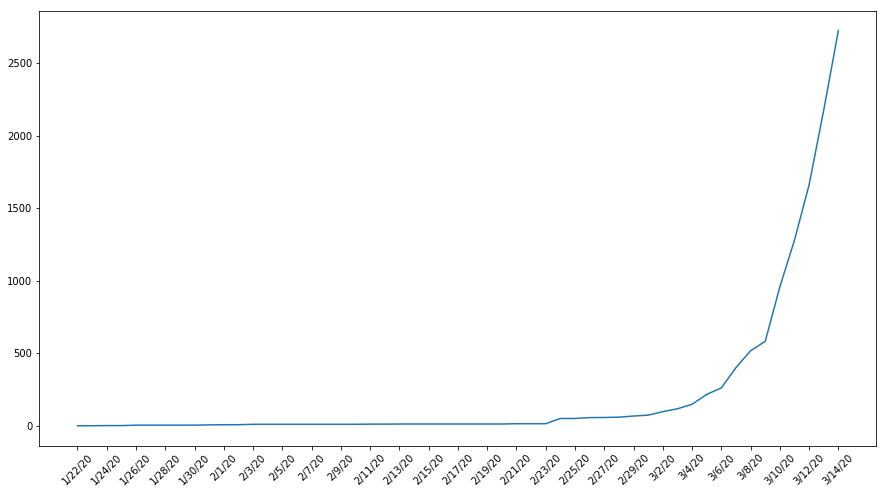

In [229]:
# plot the US confirmed covid-19 numbers
# prepare the data
dates = list(plot_df_confirmed_US.columns)
confirmed = list(plot_df_confirmed_US.values[0])
adjust_xticks = dates[::2]

# plot the data
plt.figure(figsize=[15,8])
plt.plot(dates, confirmed)
plt.xticks(adjust_xticks, rotation=45);



In [230]:
# removing unnecessary columns
df_confirmed_countries.drop(columns=['Lat', 'Long'], inplace=True)

# set the country/region column as index
df_confirmed_countries.set_index('Country/Region', inplace=True)


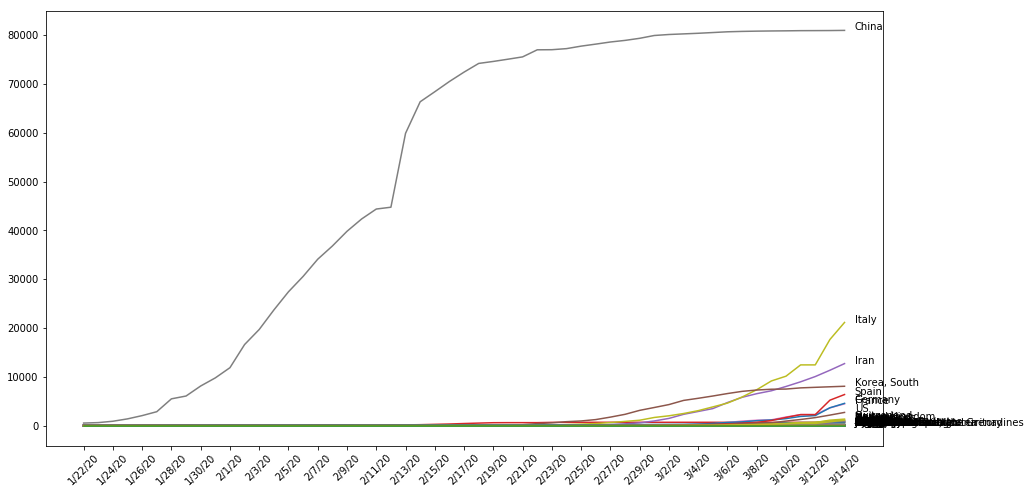

In [231]:
# plot all countries in one graph
plt.figure(figsize=[15,8])
for index, row in df_confirmed_countries.iterrows():
    plt.plot(dates, row)
    plt.annotate(index,xy=(plt.xticks()[0][-1]+0.7, row[-1]))

plt.xticks(adjust_xticks, rotation=45);
    

Based on the above graph, we can see that China has been able to contain the virus, with the growth rate significantly slowing over the past few days

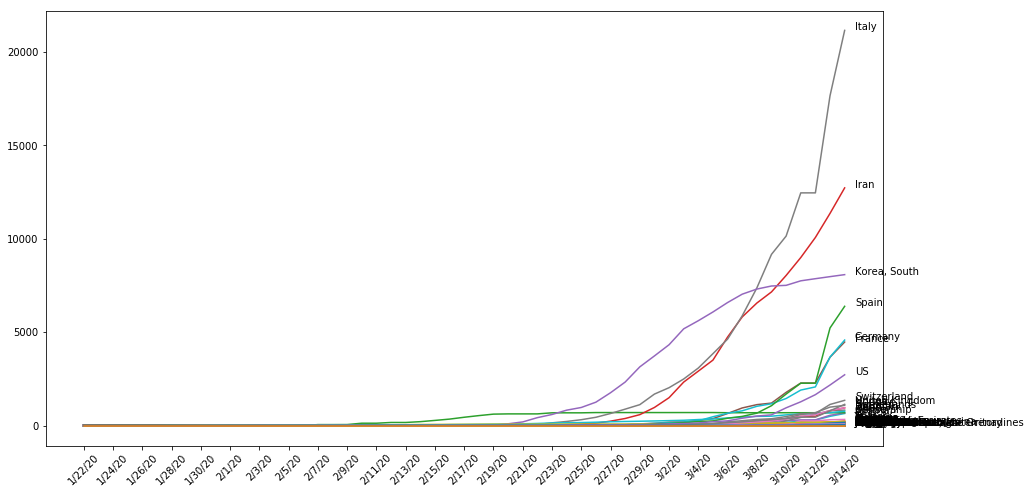

In [232]:
# plot all countries except for China
plt.figure(figsize=[15,8])
for index, row in df_confirmed_countries.iterrows():
    if index == 'China':
        pass
    else:
        plt.plot(dates, row)
        plt.annotate(index,xy=(plt.xticks()[0][-1]+0.7, row[-1]))

plt.xticks(adjust_xticks, rotation=45);


A slower growth rate can also be observed in the case of South Korea. On March 8th, Italy surpassed the number of cases in South Korea, while Iran surpassed South Korea two days later.

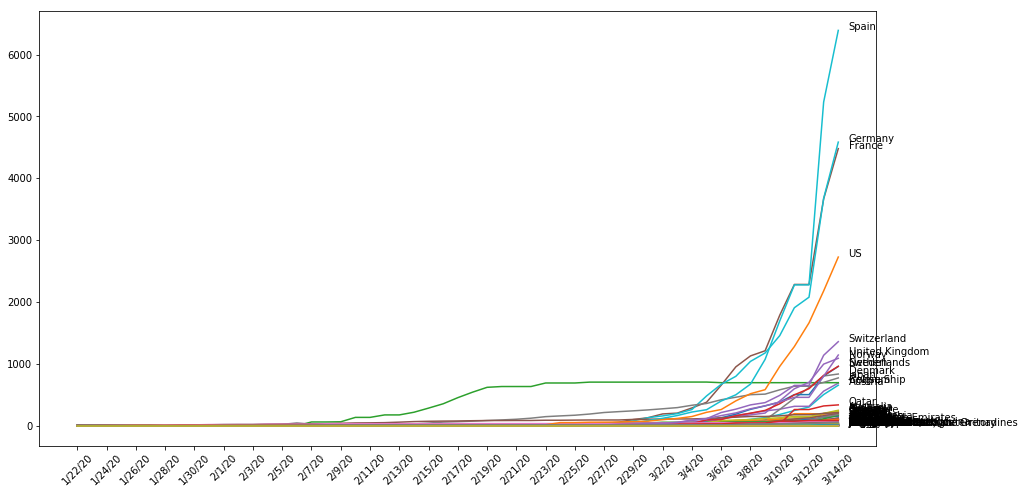

In [233]:
# plot all countries except for China, Italy, Iran and South Korea
plt.figure(figsize=[15,8])
for index, row in df_confirmed_countries.iterrows():
    if index == 'China' or index == 'Italy' or index == 'Iran' or index == 'Korea, South':
        pass
    else:
        plt.plot(dates, row)
        plt.annotate(index,xy=(plt.xticks()[0][-1]+0.7, row[-1]))

plt.xticks(adjust_xticks, rotation=45);


Looking at countries with less than 7,000 cases, it does not look like the growth is going to slow down any time soon. The light green line belongs to Cruise Ships, which were treated as their own region by the WHO. Their growth has slowed, mainly because the majority of cruise line operators have suspended their cruises amid the outbreak.

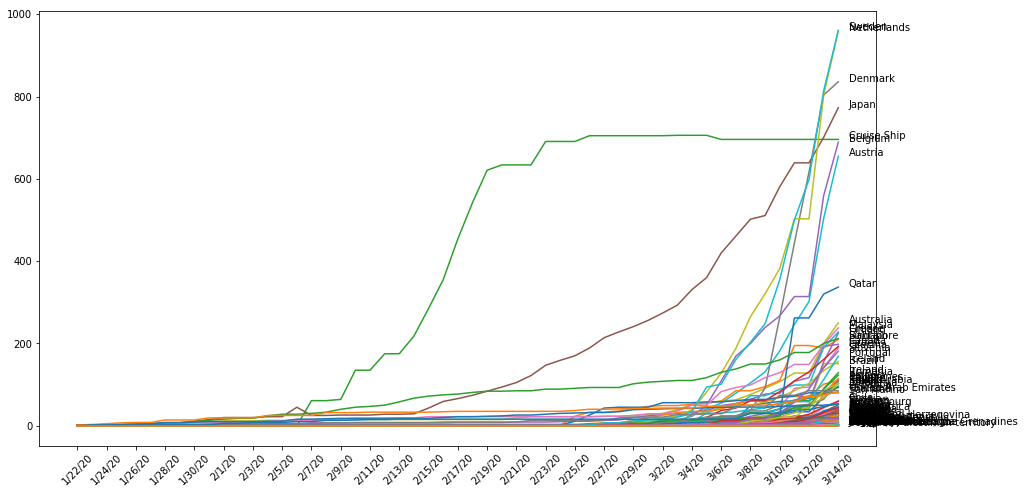

In [234]:
# plot all countries with less than 1000 cases
plt.figure(figsize=[15,8])
for index, row in df_confirmed_countries.iterrows():
    if row[-1] > 1000:
        pass
    else:
        plt.plot(dates, row)
        plt.annotate(index,xy=(plt.xticks()[0][-1]+0.7, row[-1]))

plt.xticks(adjust_xticks, rotation=45);


### News

In [225]:
# format the time so that grouping per day can be done
df_news['date'] = df_news['publish_date'].apply(lambda x: x[5:10])


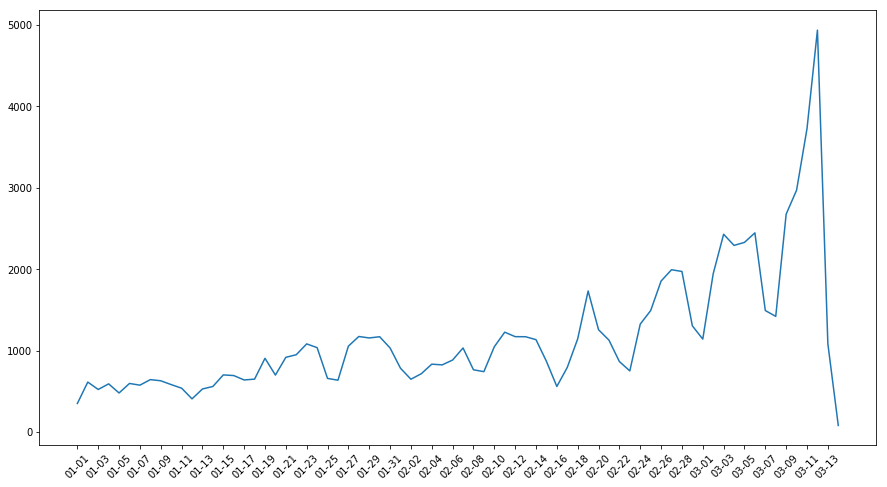

In [235]:
# get the story number for covid-19 related news
story_covid_cnt = df_news.groupby('date')['title'].count()

# plot the numbers
dates = list(story_covid_cnt.index)
story_count = list(story_covid_cnt.values)

plt.figure(figsize=[15,8])
plt.plot(dates, story_count)
adjust_xticks = dates[::2]
plt.xticks(adjust_xticks, rotation=45);


## The economic consequences
* global supply chains
* China is recovering
* stock markets and other financial assets
* what about other significant losses in history? How long until recovery?




## The political consequences
* Trump approval ratings
* fear of voters of corona virus
* news about corona versus news about biden, sanders and campaigns


